# Load all the imports! 

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold 

import seaborn as sns; 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv


# Load dataset

In [0]:
dataset = pd.read_csv('Rogoz_O_Ana_Cristina_train.csv', delimiter=",")
dataset

Setul de date este alcatuit din **1000 de exemple** a cate **9 featureuri**: Breed Name, Weight, Height, Longevity, Energy Level, Attention Needs, Coat Length, Sex, Owner Name. 


1)  Breed Name: feature categorial, poate lua 4 valori (Amstaff, Pug, Bloodhound, Jack Russel Terrier)
* Amstaff: 252 exemple
* Pug: 246
* Bloodhound: 250
* Jack Russel Terrier: 252

2) Weight: feature numeric, variaza intre 4785.075 g si 52863.3533 g

3) Height: feature numeric, variaza intre 23.186 cm si 67.8929 cm, poate contine valori NaN. 

4) Longevity: feature numeric, variaza intre 6.0778 ani si 15.7658 ani

5) Energy Level: feature categorial, poate lua 3 valori (low, med, high)
* low: 80 exemple
* med : 616 exemple
* high: 304 exemple

6) Attention Needs: feature categorial, poate lua 3 valori (low, med, high)
* low: 23 exemple
* med: 273 exemple
* high: 704 exemple

7) Coat Length: feature categorial, poate lua 2 valori(short, med) 
* short: 895 exemple
* med: 105 exemple

8) Sex: feature categorial, poate lua 2 valori(female, male)
* female: 509 exemple
* male: 491exemple

9) Owner Name: feature categorial, contine 511 valori distincte in setul de date

# Task 1: Classification

Pentru aceasta cerinta trebuie sa prezicem rasa cainilor bazandu-ne pe o serie de featureuri. 
Deoarece rasa este un feature categorial, vom folosi algoritmi de invatare potriviti pentru acest tip de problema si anume Logistic Regression, Random Forests si KNN. Pentru toti acesti alogritmi valoarea ce vrem sa reiasa pentru fiecare exemplu in parte poate lua valori intr-o multime discreta. 


Astfel, pentru a putea utiliza setul de date vom face urmatoarele **modificari**: 
* Transformam featurerurile categoriale in featureruri numerice. 
* Inlocuim valorile NaN de pe coloana 'Height(cm)' in functie de media inaltimii rasei din care face parte.
* Normalizam featureurile numerice ('Weight(g)','Height(cm)','Longevity(yrs)') folosind doua metode: StandardScaler si MinMaxScaler
* Calculam corelatia dintre Breed Name(ceea ce vrem sa prezicem) si toate celelalte featureuri pentru a decide care sunt cele mai relevante pentru problema data. 


## Asignam fiecarei coloane de feature categorial valori numerice. 

In [0]:
dataset['Breed Name'] = pd.factorize(dataset['Breed Name'])[0]
dataset['Energy level'] = pd.factorize(dataset['Energy level'])[0]
dataset['Attention Needs'] = pd.factorize(dataset['Attention Needs'])[0]
dataset['Coat Lenght'] = pd.factorize(dataset['Coat Lenght'])[0]
dataset['Sex'] = pd.factorize(dataset['Sex'])[0]
dataset['Owner Name'] = pd.factorize(dataset['Owner Name'])[0]

## Transformam valorile NaN in valoarea medie in functie de rasa.

In [0]:
dataset['Height(cm)'] = dataset.groupby(['Breed Name'])['Height(cm)'].transform(lambda x: x.fillna(x.mean()))

## Normalizam setul de date folosind StandardScaler si MinMaxScaler. 
(pastram separat cele doua seturi nou create pentru a le putea evalua pe fiecare in parte)





### datasetStandardScaled 

In [0]:
datasetStandardScaled = dataset.copy()

columnNames = ['Weight(g)','Height(cm)','Longevity(yrs)']
features = datasetStandardScaled[columnNames]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

datasetStandardScaled[columnNames] = features;

###datasetMinMaxScaled

In [0]:
datasetMinMaxScaled = dataset.copy()

columnNames = ['Weight(g)','Height(cm)','Longevity(yrs)']
features = datasetMinMaxScaled[columnNames]
scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)

datasetMinMaxScaled[columnNames] = features;

## Calculam corelatiile existente intre featureurile din setul de date. 

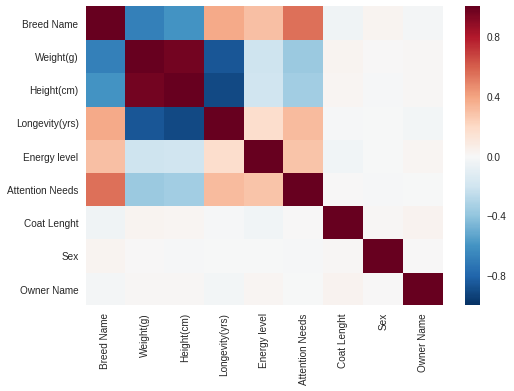

In [7]:
corr = dataset.corr()

sns.heatmap(corr);

* Din figura de mai sus putem observa ca Breed Name se coreleaza semnificativ cu Weight, Height, Longevity, Energy Level si Attention Needs. Asadar, vom exclude featurerurile Coat Length, Sex si Owner Name pe viitor (dar si 'Longevity(yrs)' conform datelor problemei). 


* Totusi, cele mai puternice doua corelatii pe care Breed Name le are sunt cu Weight si Height. Astfel, in figura de mai jos putem observa ca cele 4 rase pe care le avem de prezis se disting destul de bine doar cu ajutorul acestor doua featureruri. 

Text(0,0.5,'Height(g)')

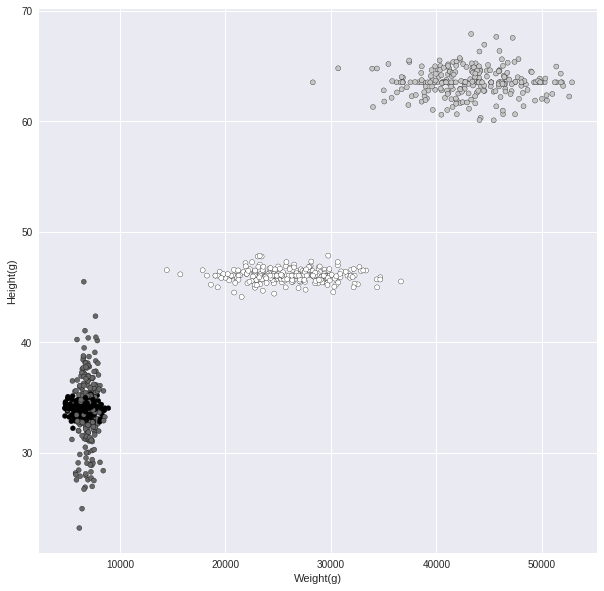

In [8]:
plt.figure(figsize=(10, 10))

plt.scatter(dataset['Weight(g)'], dataset['Height(cm)'], marker='o', c=dataset['Breed Name'],
            s=25, edgecolor='k')
plt.xlabel('Weight(g)')
plt.ylabel('Height(g)')

## Incarcam cele 3 seturi de date pe care le vom folosi la antrenare si evaluare.
* X, y, XStandardScale, yStandardScaled, XMinMaxScaled, yMinMaxScaled

In [0]:
X = dataset[['Weight(g)', 'Height(cm)',
       'Energy level', 'Attention Needs']];
y = dataset[['Breed Name']]

In [0]:
XStandardScaled = datasetStandardScaled[['Weight(g)', 'Height(cm)',
       'Energy level', 'Attention Needs']];
yStandardScaled = datasetStandardScaled[['Breed Name']]

In [0]:
XMinMaxScaled = datasetMinMaxScaled[['Weight(g)', 'Height(cm)',
       'Energy level', 'Attention Needs']];
yMinMaxScaled = datasetMinMaxScaled[['Breed Name']]

## KFold Validation. 

Cautam cei mai buni parametri pentru cei trei algoritmi de invatare. Impartim setul de intrare in 10 subseturi, fiecare dintre acestea fiind folosit o data drept set de evaluare pentru algoritmul invatat folosind restul celor 9 seturi.

### Input: 
* Setul de antrenare (X_train, y_train)

### Output:
* cea mai buna acuratete obtinuta evaluand unul dintre folduri pentru Logistic Regression, Random Forest si KNN; 
* parametri cu care am obtinut acele rezultate de acuratete pentru fiecare algoritm de invatare 
* tabel cu acuratetile fiecarui fold evaluat in parte pentru cei trei algoritmi de invatare  

In [0]:
def kFoldValidationMethod(X_train, y_train):

  kf = KFold(n_splits = 10)

  bestAccuracyLogisticRegression = 0
  bestAccuracyRandomForestClassifier = 0
  bestAccuracyKNNClassifier = 0

  accuracyTable = pd.DataFrame(columns = ['Logistic Regression', 'Random Forest', 'KNN Classifier'])
  for train_index, validation_index in kf.split(X_train):
    modelLogisticRegression = LogisticRegression().fit(X_train.iloc[train_index], y_train.iloc[train_index])
    modelRandomForestClassifier = RandomForestClassifier().fit(X_train.iloc[train_index], y_train.iloc[train_index])
    modelKNNClassifier = KNeighborsClassifier().fit(X_train.iloc[train_index], y_train.iloc[train_index])

    accuracyLogisticRegression = accuracy_score(modelLogisticRegression.predict(X_train.iloc[validation_index]), y_train.iloc[validation_index])
    accuracyRandomForestClassifier = accuracy_score(modelRandomForestClassifier.predict(X_train.iloc[validation_index]), y_train.iloc[validation_index])
    accuracyKNNClassifier = accuracy_score(modelKNNClassifier.predict(X_train.iloc[validation_index]), y_train.iloc[validation_index])

    if accuracyLogisticRegression > bestAccuracyLogisticRegression:
      bestAccuracyLogisticRegression = accuracyLogisticRegression
      paramsLogisticRegression = modelLogisticRegression.get_params()
    if accuracyRandomForestClassifier > bestAccuracyRandomForestClassifier:
      bestAccuracyRandomForestClassifier = accuracyRandomForestClassifier 
      paramsRandomForestClassifier = modelRandomForestClassifier.get_params() 
    if accuracyKNNClassifier > bestAccuracyKNNClassifier:
      bestAccuracyKNNClassifier = accuracyKNNClassifier 
      paramsKNNClassifier = modelKNNClassifier.get_params()  
    
    accuracyTable = accuracyTable.append({'Logistic Regression': accuracyLogisticRegression, 'Random Forest': accuracyRandomForestClassifier, 'KNN Classifier': accuracyKNNClassifier}, ignore_index = True)  

  return (bestAccuracyLogisticRegression, bestAccuracyRandomForestClassifier, bestAccuracyKNNClassifier, paramsLogisticRegression, paramsRandomForestClassifier, paramsKNNClassifier, accuracyTable)

### Setul de date fara normalizare. 

1) Antrenare

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
[bestAccuracyLogisticRegression, bestAccuracyRandomForestClassifier, bestAccuracyKNNClassifier, paramsLogisticRegression, paramsRandomForestClassifier, paramsKNNClassifier, accTable] = kFoldValidationMethod(X_train, y_train)


2) Analiza scorurilor de acuratete

In [14]:
accTable

,Logistic Regression,Random Forest,KNN Classifier
0,0.680000,0.973333,0.693333
1,0.786667,0.973333,0.720000
2,0.813333,0.960000,0.733333
3,0.786667,0.933333,0.826667
4,0.813333,0.986667,0.786667
5,0.853333,0.973333,0.813333
6,0.800000,0.973333,0.800000
7,0.773333,0.946667,0.760000
8,0.786667,0.960000,0.813333
9,0.786667,0.973333,0.693333


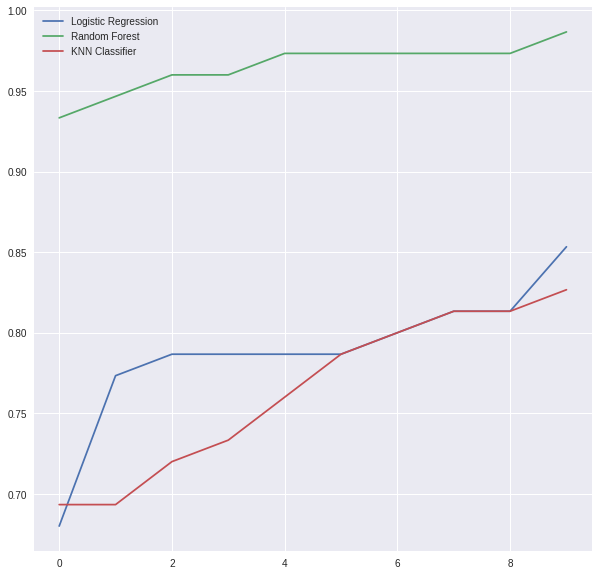

In [15]:
plt.figure(figsize=(10, 10))

plt.plot(range(10), accTable.sort_values(by='Logistic Regression')['Logistic Regression'])
plt.plot(range(10), accTable.sort_values(by='Random Forest')['Random Forest'])
plt.plot(range(10), accTable.sort_values(by='KNN Classifier')['KNN Classifier'])
plt.legend(['Logistic Regression', 'Random Forest', 'KNN Classifier'])

In [16]:
print ("Valorile maxime obtinute: %lf - Logistic Regression, %lf - Random Forest, %lf - KNN" %(bestAccuracyLogisticRegression, bestAccuracyRandomForestClassifier, bestAccuracyKNNClassifier))
print ("Valorile medii obtinute: %lf - Logistic Regression, %lf - Random Forest, %lf - KNN" %(np.mean(accTable['Logistic Regression']), np.mean(accTable['Random Forest']), np.mean(accTable['KNN Classifier'])))


Valorile maxime obtinute: 0.853333 - Logistic Regression, 0.986667 - Random Forest, 0.826667 - KNN
Valorile medii obtinute: 0.788000 - Logistic Regression, 0.965333 - Random Forest, 0.764000 - KNN


3) Testare 

Pentru a vizualiza rezultatele asupra setului de test vom evalua modelele obtinute anterior folosind parametri cu cea mai buna acuratete pentru fiecare metoda. De asemenea, folosind o matrice de confuzie, putem observa cate exemple au fost misclasificate din fiecare clasa, dar si cate au fost categorisite corespunzator.

Aceasta evaluare o vom folosi si pentru restul seturilor de date. (cu StandardScaler si cu MinMaxScaler)

In [17]:
accuracyLogisticRegression = accuracy_score(LogisticRegression().fit(X_test, y_test).set_params(**paramsLogisticRegression).predict(X_test), y_test)
accuracyRandomForestClassifier = accuracy_score(RandomForestClassifier().fit(X_test, y_test).set_params(**paramsRandomForestClassifier).predict(X_test), y_test)
accuracyKNNClassifier = accuracy_score(KNeighborsClassifier().fit(X_test, y_test).set_params(**paramsKNNClassifier).predict(X_test), y_test)

print (accuracyLogisticRegression, accuracyRandomForestClassifier, accuracyKNNClassifier)

0.796 0.992 0.852


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


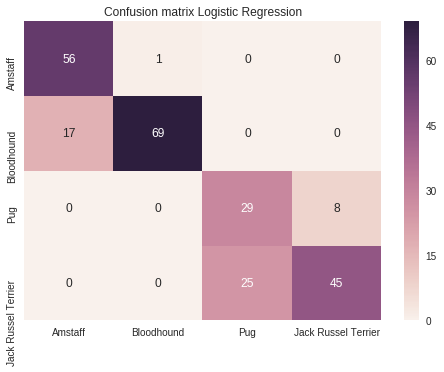

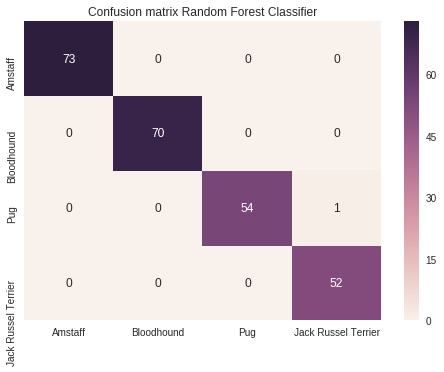

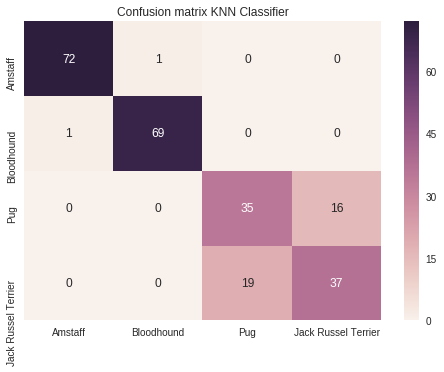

In [18]:
confusionMatrixLogisticRegression = confusion_matrix(LogisticRegression().fit(X_test, y_test).set_params(**paramsLogisticRegression).predict(X_test), y_test);
confusionMatrixRandomForestClassifier = confusion_matrix(RandomForestClassifier().fit(X_test, y_test).set_params(**paramsRandomForestClassifier).predict(X_test), y_test)
confusionMatrixKNNClassifier = confusion_matrix(KNeighborsClassifier().fit(X_test, y_test).set_params(**paramsKNNClassifier).predict(X_test), y_test)

plt.title("Confusion matrix Logistic Regression");
sns.heatmap(confusionMatrixLogisticRegression, annot=True, xticklabels=['Amstaff', 'Bloodhound', 'Pug', 'Jack Russel Terrier'], yticklabels=['Amstaff', 'Bloodhound', 'Pug', 'Jack Russel Terrier'])
plt.figure()
plt.title("Confusion matrix Random Forest Classifier");
sns.heatmap(confusionMatrixRandomForestClassifier, annot=True, xticklabels=['Amstaff', 'Bloodhound', 'Pug', 'Jack Russel Terrier'], yticklabels=['Amstaff', 'Bloodhound', 'Pug', 'Jack Russel Terrier'])
plt.figure()
plt.title("Confusion matrix KNN Classifier");
sns.heatmap(confusionMatrixKNNClassifier, annot=True, xticklabels=['Amstaff', 'Bloodhound', 'Pug', 'Jack Russel Terrier'], yticklabels=['Amstaff', 'Bloodhound', 'Pug', 'Jack Russel Terrier'])

  ### Setul de date cu StandardScaler

1) Antrenare

In [19]:
X_train, X_test, y_train, y_test = train_test_split(XStandardScaled,yStandardScaled)

[bestAccuracyLogisticRegression, bestAccuracyRandomForestClassifier, bestAccuracyKNNClassifier, paramsLogisticRegression, paramsRandomForestClassifier, paramsKNNClassifier, accTable] = kFoldValidationMethod(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=T

2) Analiza scorurilor de acuratete

In [20]:
accTable

,Logistic Regression,Random Forest,KNN Classifier
0,0.946667,1.000000,0.986667
1,0.920000,0.986667,0.986667
2,0.920000,0.986667,0.986667
3,0.946667,0.946667,0.960000
4,0.920000,0.986667,0.960000
5,0.893333,0.973333,0.960000
6,0.866667,0.973333,0.973333
7,0.946667,0.933333,0.960000
8,0.893333,0.960000,0.960000
9,0.933333,0.946667,0.920000


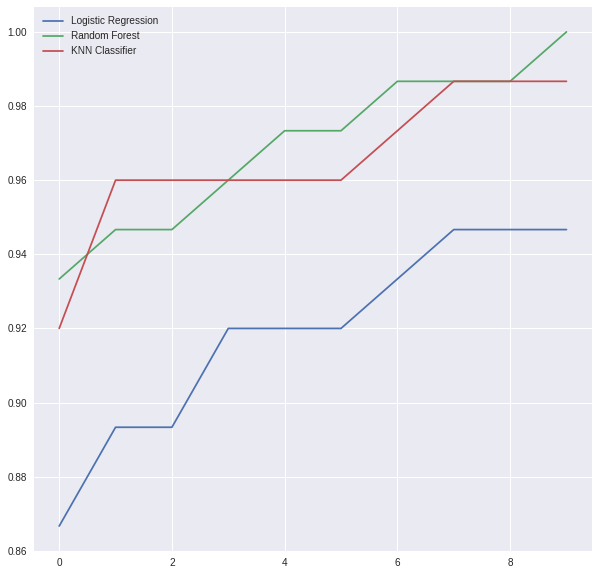

In [21]:
plt.figure(figsize=(10, 10))

plt.plot(range(10), accTable.sort_values(by='Logistic Regression')['Logistic Regression'])
plt.plot(range(10), accTable.sort_values(by='Random Forest')['Random Forest'])
plt.plot(range(10), accTable.sort_values(by='KNN Classifier')['KNN Classifier'])
plt.legend(['Logistic Regression', 'Random Forest', 'KNN Classifier'])

In [22]:
print ("Valorile maxime obtinute: %lf - Logistic Regression, %lf - Random Forest, %lf - KNN" %(bestAccuracyLogisticRegression, bestAccuracyRandomForestClassifier, bestAccuracyKNNClassifier))
print ("Valorile medii obtinute: %lf - Logistic Regression, %lf - Random Forest, %lf - KNN" %(np.mean(accTable['Logistic Regression']), np.mean(accTable['Random Forest']), np.mean(accTable['KNN Classifier'])))

Valorile maxime obtinute: 0.946667 - Logistic Regression, 1.000000 - Random Forest, 0.986667 - KNN
Valorile medii obtinute: 0.918667 - Logistic Regression, 0.969333 - Random Forest, 0.965333 - KNN


3) Testare

In [23]:
accuracyLogisticRegression = accuracy_score(LogisticRegression().fit(X_test, y_test).set_params(**paramsLogisticRegression).predict(X_test), y_test)
accuracyRandomForestClassifier = accuracy_score(RandomForestClassifier().fit(X_test, y_test).set_params(**paramsRandomForestClassifier).predict(X_test), y_test)
accuracyKNNClassifier = accuracy_score(KNeighborsClassifier().fit(X_test, y_test).set_params(**paramsKNNClassifier).predict(X_test), y_test)

print (accuracyLogisticRegression, accuracyRandomForestClassifier, accuracyKNNClassifier)

0.928 1.0 0.972


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


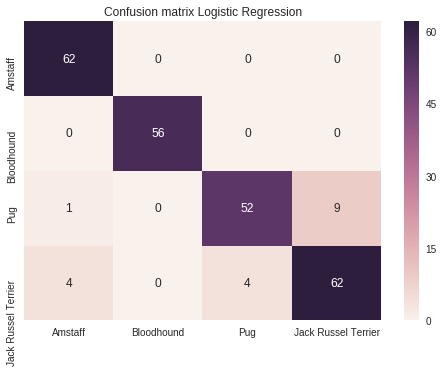

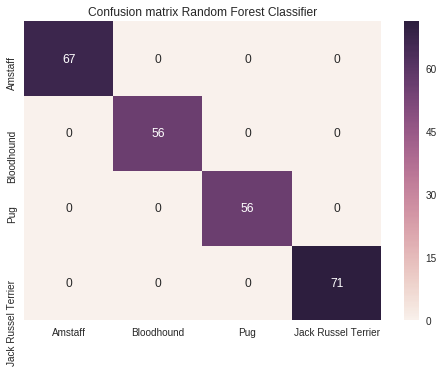

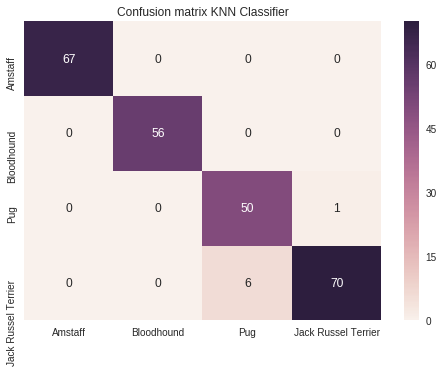

In [24]:
confusionMatrixLogisticRegression = confusion_matrix(LogisticRegression().fit(X_test, y_test).set_params(**paramsLogisticRegression).predict(X_test), y_test);
confusionMatrixRandomForestClassifier = confusion_matrix(RandomForestClassifier().fit(X_test, y_test).set_params(**paramsRandomForestClassifier).predict(X_test), y_test)
confusionMatrixKNNClassifier = confusion_matrix(KNeighborsClassifier().fit(X_test, y_test).set_params(**paramsKNNClassifier).predict(X_test), y_test)

plt.title("Confusion matrix Logistic Regression");
sns.heatmap(confusionMatrixLogisticRegression, annot=True, xticklabels=['Amstaff', 'Bloodhound', 'Pug', 'Jack Russel Terrier'], yticklabels=['Amstaff', 'Bloodhound', 'Pug', 'Jack Russel Terrier'])
plt.figure()
plt.title("Confusion matrix Random Forest Classifier");
sns.heatmap(confusionMatrixRandomForestClassifier, annot=True, xticklabels=['Amstaff', 'Bloodhound', 'Pug', 'Jack Russel Terrier'], yticklabels=['Amstaff', 'Bloodhound', 'Pug', 'Jack Russel Terrier'])
plt.figure()
plt.title("Confusion matrix KNN Classifier");
sns.heatmap(confusionMatrixKNNClassifier, annot=True, xticklabels=['Amstaff', 'Bloodhound', 'Pug', 'Jack Russel Terrier'], yticklabels=['Amstaff', 'Bloodhound', 'Pug', 'Jack Russel Terrier'])

### Setul de date cu MinMaxScaler

1) Antrenare

In [0]:
X_train, X_test, y_train, y_test = train_test_split(XMinMaxScaled,yMinMaxScaled)

[bestAccuracyLogisticRegression, bestAccuracyRandomForestClassifier, bestAccuracyKNNClassifier, paramsLogisticRegression, paramsRandomForestClassifier, paramsKNNClassifier, accTable] = kFoldValidationMethod(X_train, y_train)

2) Analiza scorurilor de acuratete

In [26]:
accTable

,Logistic Regression,Random Forest,KNN Classifier
0,0.920000,0.946667,0.933333
1,0.946667,0.986667,1.000000
2,0.946667,0.946667,0.946667
3,0.866667,0.973333,0.973333
4,0.893333,0.933333,0.960000
5,0.920000,0.960000,0.973333
6,0.960000,1.000000,0.973333
7,0.893333,0.986667,0.920000
8,0.906667,0.960000,0.960000
9,0.946667,0.946667,0.960000


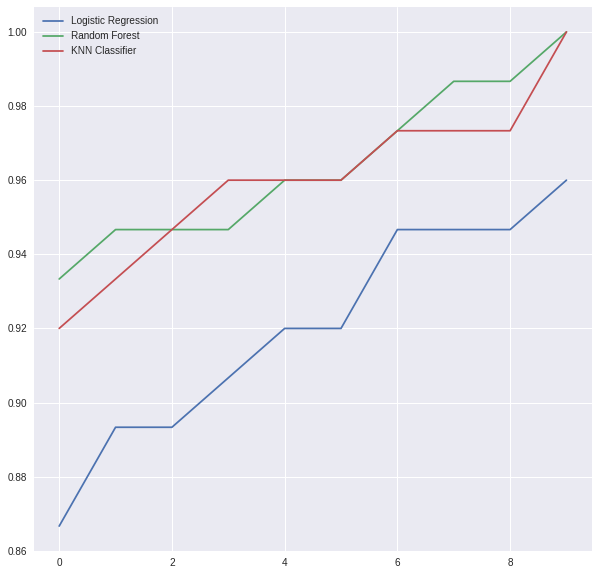

In [27]:
plt.figure(figsize=(10, 10))

plt.plot(range(10), accTable.sort_values(by='Logistic Regression')['Logistic Regression'])
plt.plot(range(10), accTable.sort_values(by='Random Forest')['Random Forest'])
plt.plot(range(10), accTable.sort_values(by='KNN Classifier')['KNN Classifier'])
plt.legend(['Logistic Regression', 'Random Forest', 'KNN Classifier'])

In [28]:
print ("Valorile maxime obtinute: %lf - Logistic Regression, %lf - Random Forest, %lf - KNN" %(bestAccuracyLogisticRegression, bestAccuracyRandomForestClassifier, bestAccuracyKNNClassifier))
print ("Valorile medii obtinute: %lf - Logistic Regression, %lf - Random Forest, %lf - KNN" %(np.mean(accTable['Logistic Regression']), np.mean(accTable['Random Forest']), np.mean(accTable['KNN Classifier'])))

Valorile maxime obtinute: 0.960000 - Logistic Regression, 1.000000 - Random Forest, 1.000000 - KNN
Valorile medii obtinute: 0.920000 - Logistic Regression, 0.964000 - Random Forest, 0.960000 - KNN


3) Testare

In [29]:
accuracyLogisticRegression = accuracy_score(LogisticRegression().fit(X_test, y_test).set_params(**paramsLogisticRegression).predict(X_test), y_test)
accuracyRandomForestClassifier = accuracy_score(RandomForestClassifier().fit(X_test, y_test).set_params(**paramsRandomForestClassifier).predict(X_test), y_test)
accuracyKNNClassifier = accuracy_score(KNeighborsClassifier().fit(X_test, y_test).set_params(**paramsKNNClassifier).predict(X_test), y_test)

print (accuracyLogisticRegression, accuracyRandomForestClassifier, accuracyKNNClassifier)

0.9 1.0 0.964


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


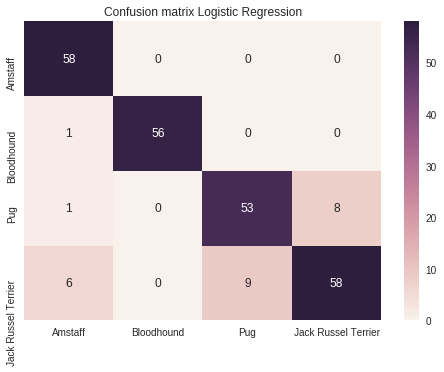

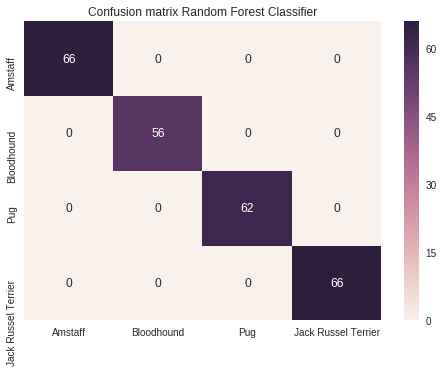

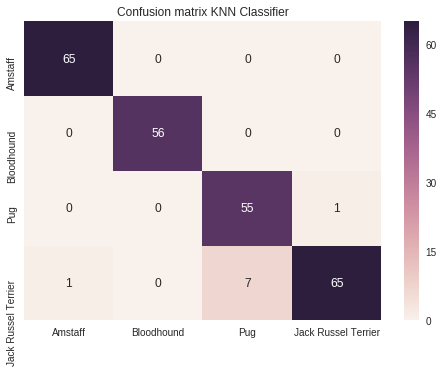

In [30]:
confusionMatrixLogisticRegression = confusion_matrix(LogisticRegression().fit(X_test, y_test).set_params(**paramsLogisticRegression).predict(X_test), y_test);
confusionMatrixRandomForestClassifier = confusion_matrix(RandomForestClassifier().fit(X_test, y_test).set_params(**paramsRandomForestClassifier).predict(X_test), y_test)
confusionMatrixKNNClassifier = confusion_matrix(KNeighborsClassifier().fit(X_test, y_test).set_params(**paramsKNNClassifier).predict(X_test), y_test)

plt.title("Confusion matrix Logistic Regression");
sns.heatmap(confusionMatrixLogisticRegression, annot=True, xticklabels=['Amstaff', 'Bloodhound', 'Pug', 'Jack Russel Terrier'], yticklabels=['Amstaff', 'Bloodhound', 'Pug', 'Jack Russel Terrier'])
plt.figure()
plt.title("Confusion matrix Random Forest Classifier");
sns.heatmap(confusionMatrixRandomForestClassifier, annot=True, xticklabels=['Amstaff', 'Bloodhound', 'Pug', 'Jack Russel Terrier'], yticklabels=['Amstaff', 'Bloodhound', 'Pug', 'Jack Russel Terrier'])
plt.figure()
plt.title("Confusion matrix KNN Classifier");
sns.heatmap(confusionMatrixKNNClassifier, annot=True, xticklabels=['Amstaff', 'Bloodhound', 'Pug', 'Jack Russel Terrier'], yticklabels=['Amstaff', 'Bloodhound', 'Pug', 'Jack Russel Terrier'])

## Conclusion 

In codul de mai sus am testat si evaluat algoritmii de invatare Logistic Regression, Random Forests si KNN pentru trei seturi de date: setul de date initial, setul de date pentru care am utilizat StandardScaler asupra featureurilor numerice si setul de date pentru care am utilizat MinMaxScaler asupra acelorasi featureruri.  

Din aceste seturi de date am vrut sa prezicem eticheta Breed Name, iar pentru aceasta ne-am folosit de urmatoarele featureuri: Height(cm), Weight(cm),  Energy Level si Attention Needs. Am impartit setul mare in set de antrenare si set de testare. Ulterior, am folosit KFold Validation pentru a gasi cei mai buni parametri pentru fiecare model in parte, impartind setul de antrenare in 10 subseturi, fiecare fiind la un moment dat setul de evaluare pentru modelul gasit antrenand pe celelalte noua. Cu acesti "cei mai buni parametri", am evaluat modelele pe setul de testare si am tras concluzii atat din scorurile de acuratete obtinute cat si din matricile de confuzie. 

Asadar, sumarizand rezultatele: 
### Antrenare
1) Pentru setul de date fara normalizari
* Logistic Regression: accuracy max = 0.86, accuracy mean = 0.78
* Random Forest: accuracy max = 0.98, accuracy mean = 0.95
* KNN: accuracy max = 0.82, accuracy mean = 0.77

2) Pentru setul cu StandardScaler 
* Logistic Regression: accuracy max = 0.97, accuracy mean = 0.92
* Random Forest: accuracy max = 1, accuracy mean = 0.969
* KNN: accuracy max = 1, accuracy mean = 0.968

3) Pentru setul cu MinMaxScaler 
* Logistic Regression: accuracy max = 0.96, accuracy mean = 0.91
* Random Forest: accuracy max = 0.98, accuracy mean = 0.968
* KNN: accuracy max = 0.98, accuracy mean = 0.960

### Testare
1) Pentru setul de date fara normalizari - Accuracy folosind:
* Logistic Regression: 0.732 
* Random Forest: 1.0 
* KNN: 0.844

2) Pentru setul cu StandardScaler - Accuracy folosind:
* Logistic Regression: 0.9 
* Random Forest: 0.996 
* KNN: 0.968

3) Pentru setul cu MinMaxScaler - Accuracy folosind:
* Logistic Regression: 0.884 
* Random Forest: 0.988
* KNN: 0.96

Astfel, in urma rezultatelor de mai sus, consider ca cel mai bun rezultat a fost gasit folosind Random Forests cu StandardScaler deoarece pentru setul de testare a obtinut o acuratete aproape maxima(clasificand gresit doar 2 exemple), iar acuratetea medie a celor 10 folduri este de asemenea cea mai mare dintre toate variantele incercate fapt ce indica stabilitatea acestei metode. 

# Task 2: Regression

Pentru aceasta cerinta trebuie sa prezicem longevitatea cainilor bazandu-ne pe o serie de featureuri. 
Deoarece rasa este un feature numeric, vom folosi algoritmi de invatare potriviti pentru acest tip de problema si anume Linear Regression si KNN. Pentru toti acesti alogritmi valoarea ce vrem sa reiasa pentru fiecare exemplu in parte poate lua valori intr-un interval.  

Avand deja setul initial de date modificat de la task-ul anterior, astfel incat toate featurerurile categoriale sunt numerice si valorile NaN de pe coloana 'Height(cm)' sunt inlocuite de media inaltimii rasei din care face parte, vom analiza si de data aceasta 3 variante ale setului de date: fara normalizari, cu StandardScaler si cu MinMaxScaler (pentru featurerurile numerice 'Weight(g)','Height(cm)','Longevity(yrs)').

De asemenea, din plotul anterior de corelatii intre featureuri, observam ca 'Longevity(yrs)' nu se coreleaza de asemenea cu 'Coat Length', 'Sex' si 'Owner Name', asadar vom exclude aceste featureuri (dar si 'Breed Name de asemenea'). 



## Incarcam cele 3 seturi de date pe care le vom folosi la antrenare si evaluare.
* X, y, XStandardScale, yStandardScaled, XMinMaxScaled, yMinMaxScaled

In [0]:
X = dataset[['Weight(g)', 'Height(cm)',
       'Energy level', 'Attention Needs']];
y = dataset[['Longevity(yrs)']]

In [0]:
XStandardScaled = datasetStandardScaled[['Weight(g)', 'Height(cm)',
       'Energy level', 'Attention Needs']];
yStandardScaled = datasetStandardScaled[['Longevity(yrs)']]

In [0]:
XMinMaxScaled = datasetMinMaxScaled[['Weight(g)', 'Height(cm)',
       'Energy level', 'Attention Needs']];
yMinMaxScaled = datasetMinMaxScaled[['Longevity(yrs)']]

## KFold Validation. 

Cautam cei mai buni parametri pentru cei doi algoritmi de invatare. Impartim setul de intrare in 10 subseturi, fiecare dintre acestea fiind folosit o data drept set de evaluare pentru algoritmul invatat folosind restul celor 9 seturi.

### Input: 
* Setul de antrenare (X_train, y_train)

### Output:
* cea mai buna eroare obtinuta evaluand unul dintre folduri pentru Linear Regression si KNN; 
* parametri cu care am obtinut acele rezultate de eroare pentru fiecare algoritm de invatare 
* tabel cu erorile fiecarui fold evaluat in parte pentru cei doi algoritmi de invatare  

In [0]:
def kFoldValidationMethod(X_train, y_train):

  kf = KFold(n_splits = 10)

  bestErrorLinearRegression = np.inf
  bestErrorKNNRegression = np.inf

  errorTable = pd.DataFrame(columns = ['Linear Regression', 'KNN Regression'])
  for train_index, validation_index in kf.split(X_train):
    modelLinearRegression = LinearRegression().fit(X_train.iloc[train_index], y_train.iloc[train_index])
    modelKNNRegression = KNeighborsRegressor().fit(X_train.iloc[train_index], y_train.iloc[train_index])

    errorLinearRegression = mean_squared_error(modelLinearRegression.predict(X_train.iloc[validation_index]), y_train.iloc[validation_index])
    errorKNNRegression = mean_squared_error(modelKNNRegression.predict(X_train.iloc[validation_index]), y_train.iloc[validation_index])

    if errorLinearRegression < bestErrorLinearRegression:
      bestErrorLinearRegression = errorLinearRegression
      paramsLinearRegression = modelLinearRegression.get_params()
    if errorKNNRegression < bestErrorKNNRegression:
      bestErrorKNNRegression = errorKNNRegression 
      paramsKNNRegression = modelKNNRegression.get_params()  
    
    errorTable = errorTable.append({'Linear Regression': errorLinearRegression, 'KNN Regression': errorKNNRegression}, ignore_index = True)  

  return (bestErrorLinearRegression, bestErrorKNNRegression, paramsLinearRegression, paramsKNNRegression, errorTable)

### Setul de date fara normalizare. 

1) Antrenare

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
[bestErrorLinearRegression, bestErrorKNNRegression, paramsLinearRegression, paramsKNNRegression, errorTable] = kFoldValidationMethod(X_train, y_train)

2) Analiza scorurilor de eroare

In [38]:
errorTable

,Linear Regression,KNN Regression
0,0.821640,1.574752
1,0.967351,0.923212
2,1.166194,0.825687
3,1.123603,0.611405
4,1.273250,0.669826
5,0.920861,0.650475
6,1.012307,0.761418
7,0.924863,0.969166
8,1.069762,1.147047
9,1.032434,0.730944


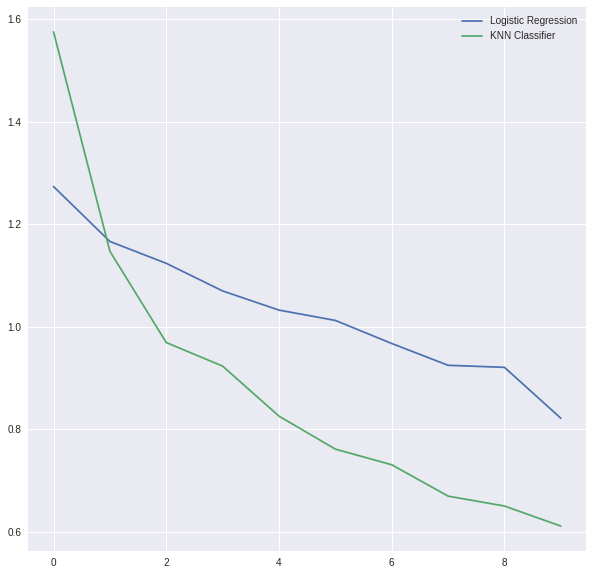

In [39]:
plt.figure(figsize=(10, 10))

plt.plot(range(10), errorTable.sort_values(by='Linear Regression', ascending=False)['Linear Regression'])
plt.plot(range(10), errorTable.sort_values(by='KNN Regression', ascending=False)['KNN Regression'])
plt.legend(['Logistic Regression','KNN Classifier'])

In [40]:
print ("Valorile minime obtinute pentru eroare: %lf - Logistic Regression, %lf - KNN" %(bestErrorLinearRegression, bestErrorKNNRegression))
print ("Valorile medii obtinute: %lf - Linear Regression, %lf - KNN" %(np.mean(errorTable['Linear Regression']), np.mean(errorTable['KNN Regression'])))


Valorile minime obtinute pentru eroare: 0.821640 - Logistic Regression, 0.611405 - KNN
Valorile medii obtinute: 1.031226 - Linear Regression, 0.886393 - KNN


3) Testare

In [41]:
errorLinearRegression = mean_squared_error(LinearRegression().fit(X_test, y_test).set_params(**paramsLinearRegression).predict(X_test), y_test)
errorKNNRegression = mean_squared_error(KNeighborsRegressor().fit(X_test, y_test).set_params(**paramsKNNRegression).predict(X_test), y_test)

print (errorLinearRegression, errorKNNRegression)

1.0150041586499126 0.5017553992335999


### Setul de date cu StandardScaler

1) Antrenare

In [0]:
X_train, X_test, y_train, y_test = train_test_split(XStandardScaled,yStandardScaled)
[bestErrorLinearRegression, bestErrorKNNRegression, paramsLinearRegression, paramsKNNRegression, errorTable] = kFoldValidationMethod(X_train, y_train)

2) Analiza scorurilor de eroare

In [43]:
errorTable

,Linear Regression,KNN Regression
0,0.210253,0.115427
1,0.162558,0.098865
2,0.181846,0.125402
3,0.164402,0.112136
4,0.192574,0.106028
5,0.136498,0.096389
6,0.248968,0.121529
7,0.226931,0.101505
8,0.155211,0.106659
9,0.223688,0.112796


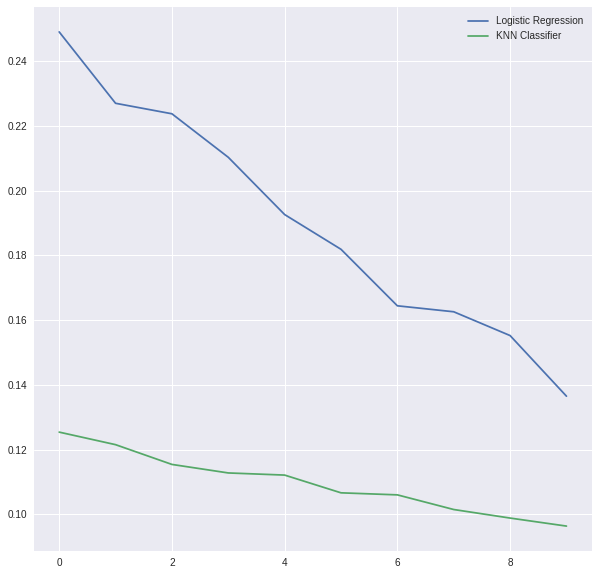

In [44]:
plt.figure(figsize=(10, 10))

plt.plot(range(10), errorTable.sort_values(by='Linear Regression', ascending=False)['Linear Regression'])
plt.plot(range(10), errorTable.sort_values(by='KNN Regression', ascending=False)['KNN Regression'])
plt.legend(['Logistic Regression','KNN Classifier'])

In [45]:
print ("Valorile minime obtinute pentru eroare: %lf - Logistic Regression, %lf - KNN" %(bestErrorLinearRegression, bestErrorKNNRegression))
print ("Valorile medii obtinute: %lf - Linear Regression, %lf - KNN" %(np.mean(errorTable['Linear Regression']), np.mean(errorTable['KNN Regression'])))


Valorile minime obtinute pentru eroare: 0.136498 - Logistic Regression, 0.096389 - KNN
Valorile medii obtinute: 0.190293 - Linear Regression, 0.109674 - KNN


3) Testare

In [46]:
errorLinearRegression = mean_squared_error(LinearRegression().fit(X_test, y_test).set_params(**paramsLinearRegression).predict(X_test), y_test)
errorKNNRegression = mean_squared_error(KNeighborsRegressor().fit(X_test, y_test).set_params(**paramsKNNRegression).predict(X_test), y_test)

print (errorLinearRegression, errorKNNRegression)

0.1856041004074121 0.09434217951285183


### Setul de date cu MinMaxScaler

1) Antrenare

In [0]:
X_train, X_test, y_train, y_test = train_test_split(XMinMaxScaled,yMinMaxScaled)
[bestErrorLinearRegression, bestErrorKNNRegression, paramsLinearRegression, paramsKNNRegression, errorTable] = kFoldValidationMethod(X_train, y_train)

2) Analiza scorurilor de eroare

In [48]:
errorTable

,Linear Regression,KNN Regression
0,0.009493,0.008008
1,0.010666,0.007966
2,0.013522,0.012421
3,0.012533,0.006319
4,0.011213,0.007547
5,0.008676,0.006918
6,0.010364,0.006245
7,0.010097,0.010452
8,0.010597,0.007378
9,0.012541,0.007999


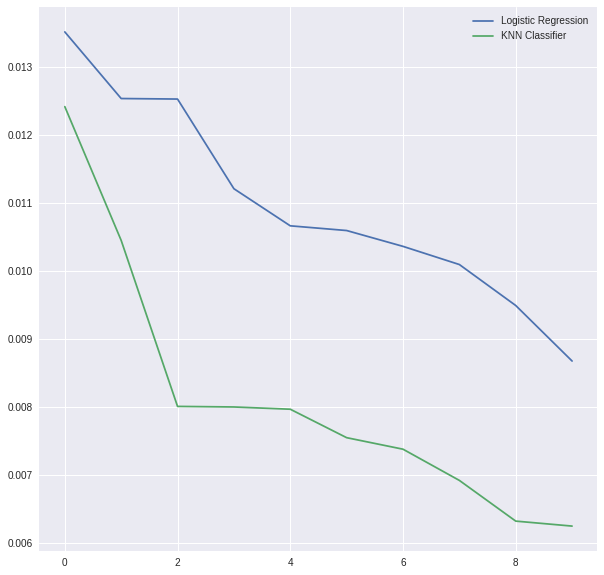

In [49]:
plt.figure(figsize=(10, 10))

plt.plot(range(10), errorTable.sort_values(by='Linear Regression', ascending=False)['Linear Regression'])
plt.plot(range(10), errorTable.sort_values(by='KNN Regression', ascending=False)['KNN Regression'])
plt.legend(['Logistic Regression','KNN Classifier'])

In [50]:
print ("Valorile minime obtinute pentru eroare: %lf - Logistic Regression, %lf - KNN" %(bestErrorLinearRegression, bestErrorKNNRegression))
print ("Valorile medii obtinute: %lf - Linear Regression, %lf - KNN" %(np.mean(errorTable['Linear Regression']), np.mean(errorTable['KNN Regression'])))


Valorile minime obtinute pentru eroare: 0.008676 - Logistic Regression, 0.006245 - KNN
Valorile medii obtinute: 0.010970 - Linear Regression, 0.008125 - KNN


3) Testare

In [51]:
errorLinearRegression = mean_squared_error(LinearRegression().fit(X_test, y_test).set_params(**paramsLinearRegression).predict(X_test), y_test)
errorKNNRegression = mean_squared_error(KNeighborsRegressor().fit(X_test, y_test).set_params(**paramsKNNRegression).predict(X_test), y_test)

print (errorLinearRegression, errorKNNRegression)

0.010881161873261679 0.005499285839599296


## Conclusion

In codul de mai sus am testat si evaluat algoritmii de invatare Linear Regression si KNN pentru trei seturi de date: setul de date initial, setul de date pentru care am utilizat StandardScaler asupra featureurilor numerice si setul de date pentru care am utilizat MinMaxScaler asupra acelorasi featureruri.  

Din aceste seturi de date am vrut sa prezicem eticheta 'Longevity(yrs)', iar pentru aceasta ne-am folosit de urmatoarele featureuri: Height(cm), Weight(cm),  Energy Level si Attention Needs. Am impartit setul mare in set de antrenare si set de testare. Ulterior, am folosit KFold Validation pentru a gasi cei mai buni parametri pentru fiecare model in parte, impartind setul de antrenare in 10 subseturi, fiecare fiind la un moment dat setul de evaluare pentru modelul gasit antrenand pe celelalte noua.  Cu acesti "cei mai buni parametri", am evaluat modelele pe setul de testare si am tras concluzii atat din scorurile de acuratete obtinute cat si din matricile de confuzie. 

Asadar, sumarizand rezultatele: 
### Antrenare
1) Pentru setul de date fara normalizari
* Logistic Regression: error min = 0.82, error mean = 1.03
* KNN: error min = 0.61, error mean = 0.88

2) Pentru setul cu StandardScaler 
* Logistic Regression: error min = 0.13, error mean = 0.19
* KNN: error min = 0.09, error mean = 0.10

3) Pentru setul cu MinMaxScaler 
* Logistic Regression: error min = 0.008, error mean = 0.0109
* KNN: error min = 0.006, error mean =  0.0081

### Testare
1) Pentru setul de date fara normalizari - mean squared error folosind:
* Logistic Regression: 1.015 
* KNN: 0.501

2) Pentru setul cu StandardScaler -  mean squared error folosind:
* Logistic Regression: 0.185
* KNN: 0.094

3) Pentru setul cu MinMaxScaler - mean squared error folosind:
* Logistic Regression: 0.010
* KNN: 0.0054

Astfel, in urma rezultatelor de mai sus, consider ca cel mai bun rezultat a fost gasit folosind KNN cu MinMaxScaler deoarece pentru setul de testare a obtinut cea mai buna eroare, iar eroarea medie a celor 10 folduri este de asemenea cea mai mica dintre toate variantele incercate fapt ce indica stabilitatea acestei metode. 